In [2]:
"""
The similarity of the same network should always be 1.0 on same input.
"""
import torch
import torch.nn as nn

import uutils.torch_uu
from uutils.torch_uu import cxa_sim, approx_equal
from uutils.torch_uu.models import get_named_identity_one_layer_linear_model

print('--- Sanity check: sCCA = 1.0 when using same net twice with same input. --')

Din: int = 10
Dout: int = Din
B: int = 2000
mdl1: nn.Module = get_named_identity_one_layer_linear_model(D=Din)
mdl2: nn.Module = mdl1
layer_name = 'fc0'
# cxa_dist_type = 'pwcca'
cxa_dist_type = 'svcca'

# - ends up comparing two matrices of size [B, Dout], on same data, on same model
X: torch.Tensor = torch.distributions.Normal(loc=0.0, scale=1.0).sample((B, Din))
sim: float = cxa_sim(mdl1, mdl2, X, layer_name, downsample_size=None, iters=1, cxa_dist_type=cxa_dist_type)

print(f'Should be very very close to 1.0: {sim=}')
print(f'Is it close to 1.0? {approx_equal(sim, 1.0)}')
assert(approx_equal(sim, 1.0))

--- Sanity check: sCCA = 1.0 when using same net twice with same input. --
Should be very very close to 1.0: sim=1.0000001192092896
Is it close to 1.0? True
--- Sanity check: sCCA = 1.0 when using same net twice with same input. --
Should be very very close to 1.0: sim=1.0
Is it close to 1.0? True



--- Sanity check: when number of data points B is smaller than D, then it should be trivial to make similiarty 1.0 (even if nets/matrices are different)
Should be very very close to 1.0: sim=1.000000238418579 (since we have many features to match the two Xw1, Yw2).
Is it close to 1.0? True

-- Santity: just makes sure that when low data is present sim is high and afterwards (as n->infty) sim (CCA) converges to the "true" cca value (eventually)
sims=[1.000000238418579, 0.9999997019767761, 1.0, 0.982517421245575, 0.9817044734954834, 0.9652864336967468, 0.6948387026786804, 0.4731246829032898, 0.33072352409362793, 0.20759665966033936, 0.14705777168273926]


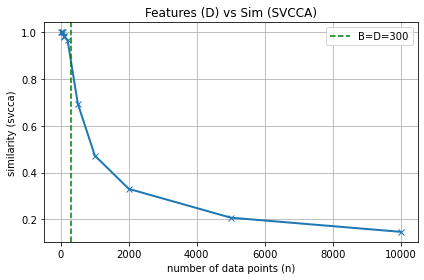

In [3]:
"""
Reproducing: How many data points: https://github.com/google/svcca/blob/master/tutorials/001_Introduction.ipynb

As n increases, the cca sim should decrease until it converges to the true max linear correlation in the data.
This is because when D is small it's easy to correlate via Xw, Yw since there are less equations (m data) than unknown (D features).
Similarly, the similarity decreases because the more data there is, the more variation has to be captured and thus the less
correlation there will be.
This is correct because 1/4*E[|| Xw - Yw||^2]^2 is proportional the pearson's correlation (assuming Xw, Yw is standardized).

"""
from pathlib import Path
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

import uutils
from uutils.torch_uu import cxa_sim, approx_equal
from uutils.torch_uu.models import get_named_one_layer_random_linear_model

import uutils.plot as uulot

print('\n--- Sanity check: when number of data points B is smaller than D, then it should be trivial to make similiarty 1.0 '
      '(even if nets/matrices are different)')
B: int = 10
Dout: int = 300
mdl1: nn.Module = get_named_one_layer_random_linear_model(B, Dout)
mdl2: nn.Module = get_named_one_layer_random_linear_model(B, Dout)
layer_name = 'fc0'
# cxa_dist_type = 'pwcca'
cxa_dist_type = 'svcca'

# - get sim for B << D e.g. [B=10, D=300] easy to "fit", to many degrees of freedom
X: torch.Tensor = uutils.torch_uu.get_identity_data(B)
# mdl1(X) : [B, Dout] = [B, B] [B, Dout]
sim: float = cxa_sim(mdl1, mdl2, X, layer_name, downsample_size=None, iters=1, cxa_dist_type=cxa_dist_type)
print(f'Should be very very close to 1.0: {sim=} (since we have many features to match the two Xw1, Yw2).')
print(f'Is it close to 1.0? {approx_equal(sim, 1.0)}')
# assert(approx_equal(sim, 1.0))

print('\n-- Santity: just makes sure that when low data is present sim is high and afterwards (as n->infty) sim (CCA) '
      'converges to the "true" cca value (eventually)')
# data_sizes: list[int] = [10, 25, 50, 100, 101, 200, 500, 1_000, 2_000, 5_000]
data_sizes: list[int] = [10, 25, 50, 100, 101, 200, 500, 1_000, 2_000, 5_000, 10_000]
# data_sizes: list[int] = [10, 25, 50, 100, 101, 200, 500, 1_000, 2_000, 5_000, 10_000, 50_000, 100_000]
# data_sizes: list[int] = [10, 25, 50, 100, 200, 500, 1_000, 2_000, 5_000, 10_000]
sims: list[float] = []
for b in data_sizes:
    X: torch.Tensor = uutils.torch_uu.get_identity_data(b)
    mdl1: nn.Module = get_named_one_layer_random_linear_model(b, Dout)
    mdl2: nn.Module = get_named_one_layer_random_linear_model(b, Dout)
    # print(f'{b=}')
    sim: float = cxa_sim(mdl1, mdl2, X, layer_name, downsample_size=None, iters=1, cxa_dist_type=cxa_dist_type)
    # print(f'{sim=}')
    sims.append(sim)

print(f'{sims=}')
uulot.plot(x=data_sizes, y=sims, xlabel='number of data points (n)', ylabel='similarity (svcca)', show=True, save_plot=True, plot_filename='ndata_vs_svcca_sim', title='Features (D) vs Sim (SVCCA)', x_hline=Dout, x_hline_label=f'B=D={Dout}')

Should be very very close to 1.0: sim=1.0
Is it close to 1.0? True
sims=[0.15554457902908325, 0.2431279420852661, 0.3558063507080078, 0.49847471714019775, 0.5043396949768066, 0.7314853072166443, 0.970008373260498, 0.9818077683448792, 0.987656831741333, 0.9876914024353027, 0.9909507036209106]


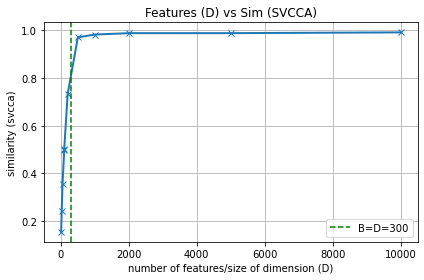

In [4]:
from pathlib import Path
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

import uutils
from uutils.torch_uu import cxa_sim, approx_equal
from uutils.torch_uu.models import get_named_one_layer_random_linear_model

from uutils.plot import plot, save_to_desktop
import uutils.plot as uuplot

B: int = 10  # [101, 200, 500, 1000, 2000, 5000, 10000]
Din: int = B
Dout: int = 300
mdl1: nn.Module = get_named_one_layer_random_linear_model(Din, Dout)
mdl2: nn.Module = get_named_one_layer_random_linear_model(Din, Dout)
layer_name = 'fc0'
# cxa_dist_type = 'pwcca'
cxa_dist_type = 'svcca'

X: torch.Tensor = uutils.torch_uu.get_identity_data(B)
sim: float = cxa_sim(mdl1, mdl2, X, layer_name, downsample_size=None, iters=1, cxa_dist_type=cxa_dist_type)

print(f'Should be very very close to 1.0: {sim=}')
print(f'Is it close to 1.0? {approx_equal(sim, 1.0)}')

# data_sizes: list[int] = [10, 25, 50, 100, 101, 200, 500, 1_000, 2_000, 5_000, 10_000, 50_000]
B: int = 300
D_feature_sizes: list[int] = [10, 25, 50, 100, 101, 200, 500, 1_000, 2_000, 5_000, 10_000]
sims: list[float] = []
for d in D_feature_sizes:
    X: torch.Tensor = uutils.torch_uu.get_identity_data(B)
    mdl1: nn.Module = get_named_one_layer_random_linear_model(B, d)
    mdl2: nn.Module = get_named_one_layer_random_linear_model(B, d)
    sim: float = cxa_sim(mdl1, mdl2, X, layer_name, downsample_size=None, iters=1, cxa_dist_type=cxa_dist_type)
    # print(f'{d=}, {sim=}')
    sims.append(sim)

print(f'{sims=}')
uuplot.plot(x=D_feature_sizes, y=sims, xlabel='number of features/size of dimension (D)', ylabel='similarity (svcca)', show=True, save_plot=True, plot_filename='D_vs_sim_svcca', title='Features (D) vs Sim (SVCCA)', x_hline=B, x_hline_label=f'B=D={B}')
# uuplot.plot(x=D_feature_sizes, y=sims, xlabel='number of features/size of dimension (D)', ylabel='similarity (svcca)', show=True, save_plot=True, plot_filename='D_vs_sim', title='Features (D) vs Sim (SVCCA)')
